In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score, f1_score
import json
import numpy as np
from model import GuarddogWrapper
from utils import Package
import joblib
import pandas as pd

NUM_FOLDS = 5

OUT_PATH = os.path.dirname(os.path.realpath(__file__)).rsplit('/', 1)[0] + '/out'
DATA_BASE_PATH = os.path.dirname(os.path.realpath(__file__)).rsplit('/', 1)[0] + '/data'

MODELS = ['dt', 'rf', 'xgboost', 'xgboost_retrained']
TRAINING_RESULTS_PATH = os.path.join(OUT_PATH, 'training_results_malwarebench/training_results_pypi')
TRAINING_RESULTS_SOA_FEATURES_PATH = os.path.join(OUT_PATH, 'training_results_malwarebench/training_results_pypi_soa_features')
DATASET_PATH = os.path.join(OUT_PATH, 'dataset_pypi_malwarebench.csv')
DATASET_PATH_SOA_FEATURES = os.path.join(OUT_PATH, 'dataset_pypi_malwarebench_soa_features.csv')
DATA_FOLDS_BASE_PATH = os.path.join(DATA_BASE_PATH, 'dataset_test_folds_malwarebench')
DATA_FOLDS_BASE_PATH_SOA_FEATURES = os.path.join(DATA_BASE_PATH, 'dataset_test_folds_malwarebench_new_features')
DATA_ADV_BASE_PATH = os.path.join(DATA_BASE_PATH, 'dataset_adv_{model}_malwarebench')
DATA_ADV_BASE_PATH_SOA_FEATURES = os.path.join(DATA_BASE_PATH, 'dataset_adv_{model}_malwarebench_new_features')
RESULTS_BASE_PATH = os.path.join(OUT_PATH, 'eval_results_malwarebench')
SCORES_RESULTS_GUARDDOG = os.path.join(OUT_PATH, 'scores_guarddog_malwarebench.json')

DATASET_NEW_PACKAGES_SOA_FEATURES_LIVE_FULL = os.path.join(OUT_PATH, 'dataset_pypi_live_full_new_features.csv')

ML_MODELS = ['dt', 'rf', 'xgboost']
ML_MODELS_ADVTRAIN = ['xgboost', 'xgboost_retrained_20'] 

MODELS_PLOT_ROC_ADV = ['xgboost', 'xgboost_retrained_20']
TRAINING_RESULTS_ADV_PATH = os.path.join(OUT_PATH, 'training_results_malwarebench/training_results_pypi_advtrain_20_sorted')
TRAINING_RESULTS_ADV_SOA_FEATURES_PATH = os.path.join(OUT_PATH, 'training_results_malwarebench/training_results_pypi_advtrain_new_features_20_sorted')

In [2]:
def get_threshold_at_fpr(labels, scores, max_fpr):
    fpr_list, tpr_list, thresholds = roc_curve(labels, scores, drop_intermediate=True)
    best_tpr = tpr_list[0]
    best_threshold = thresholds[0]

    for fpr, tpr, threshold in zip(fpr_list[1:], tpr_list[1:], thresholds[1:]):
        if fpr <= max_fpr:
            if tpr > best_tpr:
                best_tpr = tpr
                best_threshold = threshold

    return best_threshold

In [ ]:
def predict_scores(model_name, fold, df_test, new_features=False):
    if model_name == 'guarddog':
        packages = df_test['Package Name'].values
        with open(SCORES_RESULTS_GUARDDOG, 'r') as f:
            results = json.load(f)
        scores = [results[package] for package in packages]
        return scores
    else:
        model_basename = model_name.split('_')[0]

        if "retrained" in model_name:
            models_base_path = TRAINING_RESULTS_ADV_SOA_FEATURES_PATH if new_features else TRAINING_RESULTS_ADV_PATH
            model_path = os.path.join(models_base_path, f'result_{fold}', f'{model_basename}_fold{fold}.joblib')
        else:
            models_base_path = TRAINING_RESULTS_SOA_FEATURES_PATH if new_features else TRAINING_RESULTS_PATH
            model_path = os.path.join(models_base_path, f'result_{fold}', f'{model_basename}_fold{fold}.joblib')
        model = joblib.load(model_path)
        df_test = df_test.drop(columns=['Package Name', 'label'])
        return model.predict_proba(df_test.values)[:, 1].tolist()

In [ ]:
def plot_roc_avg(y_true, y_scores, label, ax=None, settings=None, add_title=False, plot_rand_guessing=False,
                 save_path=None, log_scale=True, add_label=True, legend_settings=None, plot_variance=False):

    tprs = []
    base_fpr = np.linspace(0, 1, 1001)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    if settings is not None and isinstance(settings, dict):
        ax_settings = settings.copy()
    else:
        ax_settings = dict(lw=2)
    
    for y_true_fold, y_scores_fold in zip(y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true_fold, y_scores_fold)

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    # mean_tprs = np.clip(mean_tprs, 0, 1)
    std = tprs.std(axis=0)

    if add_label:
        # ax_settings['label'] = "{}, auc={:.2f}".format(label, roc_auc)
        if '-SOA' in label:
            label = label.replace('-SOA', '')
        ax_settings['label'] = label

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    ax.plot(base_fpr, mean_tprs, **ax_settings)
    if plot_variance:
        ax.fill_between(base_fpr, tprs_lower, tprs_upper, color=ax_settings.get('color', 'grey'), alpha=0.2, label=None)

    if plot_rand_guessing:
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    if log_scale:
        ax.set_xscale('log')
        ax.set_xlim([0.00008, 1.05])
    else:
        ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)", fontsize=14)
    ax.set_ylabel("True Positive Rate (TPR)", fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)

    # change ticks labels on x-axis
    ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1], ['0.001%', '0.1%', '1%', '10%', '100%'])
    # change ticks labels on y-axis
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0%', '20%', '40%', '60%', '80%', '100%'])

    if add_title:
        ax.set_title("ROC {}".format(label), fontsize=14)
    if legend_settings is not None:
        # legend_settings = {'loc': 'lower right'}
        ax.legend(**legend_settings)
    ax.grid(True)

    if save_path is not None and fig is not None:
        plt.savefig(save_path, bbox_inches='tight')

In [ ]:
def make_roc(max_fpr=0.01, title_plot=None, query_limit_plot=None, save_fig=True, plot_vline=False, plot_transformations_xaxsis=False, use_roc_avg=True, plot_variance=False):

    plot_settings_roc_adv_models = {
        # dt
        'dt_soa-test': {'color': '#e41a1c', 'linestyle': '-'},
        'dt_soa-test-adv': {'color': '#e41a1c', 'linestyle': '--'},
        # rf
        'rf_soa-test': {'color': '#4daf4a', 'linestyle': '-'},
        'rf_soa-test-adv': {'color': '#4daf4a', 'linestyle': '--'},
        # xgboost
        'xgboost_soa-test': {'color': '#17becf', 'linestyle': '-'},
        'xgboost_soa-test-adv': {'color': '#17becf', 'linestyle': '--'},
        # xgboost_retrained
        'xgboost_soa_retrained-test': {'color': '#1f77b4', 'linestyle': '-'},
        'xgboost_soa_retrained-test-adv': {'color': '#1f77b4', 'linestyle': '--'},
        # guarddog
        'guarddog-test': {'color': '#ff7f00', 'linestyle': '-'},
        'guarddog-test-adv': {'color': '#ff7f00', 'linestyle': '--'}
    }

    title_plot = title_plot if title_plot is not None else "roc_malwarebench.pdf"

    fig_roc_adv, ax_roc_adv = plt.subplots(1, 1)

    plot_roc_func = plot_roc_avg if use_roc_avg else plot_roc

    df_results = []
    for model in ML_MODELS + ['xgboost_retrained_20', 'guarddog']:
        dr_values = []
        dr_adv_values = []
        labels, scores = [], []
        labels_test_adv, scores_test_adv = [], []
        for fold in range(NUM_FOLDS-1):
            test_indices_path = os.path.join(TRAINING_RESULTS_SOA_FEATURES_PATH, f"test_indices_fold{fold+1}.json")
            dataset_path = DATASET_PATH_SOA_FEATURES

            with open(test_indices_path) as file:
                test_indices = json.load(file)

            dataset = pd.read_csv(dataset_path)

            test_samples_df = dataset[dataset.index.isin(test_indices)]

            labels_fold = test_samples_df['label'].values.tolist()
            scores_fold = predict_scores(model, fold+1, test_samples_df, new_features=True)
            labels.append(labels_fold)
            scores.append(scores_fold)
            threshold = get_threshold_at_fpr(labels_fold, scores_fold, max_fpr)
            
            predicted = (scores_fold >= threshold).astype(int)
            dr = recall_score(labels_fold, predicted)
            dr_values.append(dr)

            if model != 'guarddog':
                if 'retrained' in model:
                    results_filepath = os.path.join(RESULTS_BASE_PATH, f'result_xgboost_retrained_20_fold{fold+1}_soa_features.json')
                else:
                    results_filepath = os.path.join(RESULTS_BASE_PATH, f'result_{model}_fold{fold+1}_soa_features.json')
            else:
                results_filepath = os.path.join(RESULTS_BASE_PATH, f"result_{model}_fold{fold+1}.json")

            with open(results_filepath) as fp:
                samples_results = fp.readlines()

            idx = 0
            num_samples = len(samples_results)
            col = len(eval(json.loads(samples_results[0])['scores_trace']))
            data_model = np.zeros((num_samples, col))
            # scores_fold_malicious_adv = []

            for result in samples_results:
                data = json.loads(result)

                scores_trace = eval(data['scores_trace'])
                # scores_fold_malicious_adv.append(scores_trace[0][1])
                score_values = []
                transformations = []

                for _, score, transformation in scores_trace:
                    if not score_values:
                        score_values.append(score)
                    else:
                        if score <= score_values[-1]:
                            score_values.append(score)
                        else:
                            score_values.append(score_values[-1])
                    transformations.append(transformation)

                data_model[idx, :] = score_values
                idx += 1

            benign_samples_df = test_samples_df[test_samples_df['label'] == 0]
            scores_fold_benign = predict_scores(model, fold+1, benign_samples_df, new_features=True)
            scores_fold_malicious_adv = data_model[:, -1].tolist()
            labels_fold_adv = [1] * len(scores_fold_malicious_adv) + [0] * len(scores_fold_benign)
            scores_fold_adv = scores_fold_malicious_adv + scores_fold_benign
            labels_test_adv.append(labels_fold_adv)
            scores_test_adv.append(scores_fold_adv)

            threshold_adv = get_threshold_at_fpr(labels_fold_adv, scores_fold_adv, max_fpr)
            predicted_adv = (scores_fold_adv >= threshold_adv).astype(int)
            dr_adv = recall_score(labels_fold_adv, predicted_adv)
            dr_adv_values.append(dr_adv)

        dr_model = np.mean(dr_values) * 100
        dr_adv_model = np.mean(dr_adv_values) * 100
        df_results.append([model, dr_model, dr_adv_model])

        if 'xgboost' in model:
            plot_label = 'XGB'
        elif model == 'guarddog':
            plot_label = 'GD'
        else:
            plot_label = model.upper()
        model_label = model.split('_')[0]

        if model != 'guarddog':
            plot_label += '-SOA'
            model_label += '_soa'

        if 'retrained' in model:
            plot_label += '-AT'
            model_label += '_retrained'

        if not use_roc_avg:
            labels = [value for sublist in labels for value in sublist]
            scores = [value for sublist in scores for value in sublist]
            labels_test_adv = [value for sublist in labels_test_adv for value in sublist]
            scores_test_adv = [value for sublist in scores_test_adv for value in sublist]

        plot_roc_func(labels, scores, plot_label + " test", ax=ax_roc_adv, settings=plot_settings_roc_adv_models[model_label + '-test'], add_label=True, plot_rand_guessing=False,
                        log_scale=True, legend_settings=None, plot_variance=plot_variance)
        plot_roc_func(labels_test_adv, scores_test_adv, plot_label + " test-adv", ax=ax_roc_adv, settings=plot_settings_roc_adv_models[model_label + '-test-adv'], add_label=True,
                        plot_rand_guessing=False, log_scale=True, legend_settings=None, plot_variance=plot_variance)

    df_results = pd.DataFrame(df_results, columns=['detector', 'test', 'test-adv'])
    df_results.to_csv('results_malwarebench.csv', index=False)
    
    fig_roc_adv.set_size_inches(6, 5)
    fig_roc_adv.tight_layout()
    # fig_roc_adv.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=2, fontsize=12)

    handles, labels = ax_roc_adv.get_legend_handles_labels()
    # order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 9]
    order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9]
    fig_roc_adv.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=2, fontsize=12)

    if save_fig:
        fig_roc_adv.savefig(title_plot, dpi=1200, format='pdf', bbox_inches="tight")

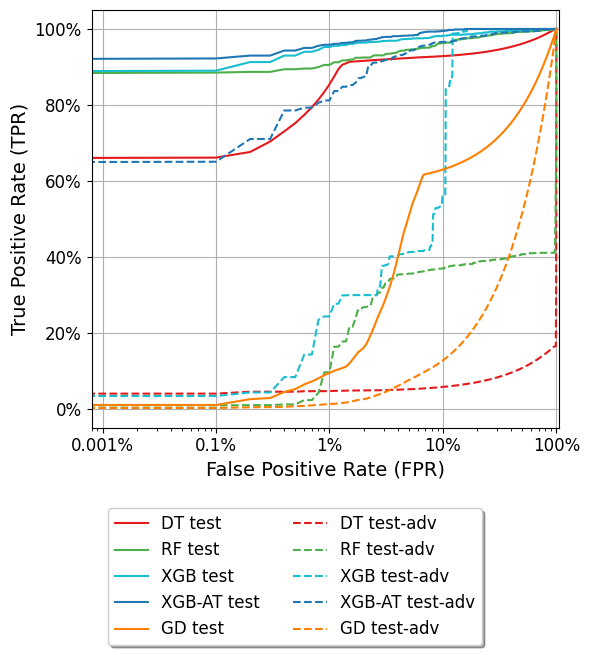

In [ ]:
make_roc(max_fpr=0.01)